In [1]:
from timeit import default_timer as timer

from matplotlib import pyplot as plt
import numpy as np
import torch
import gpytorch

from reggae.gp.exact import AnalyticalLFM
from reggae.data_loaders import load_barenco_puma
from reggae.gp.options import Options
from reggae.plot.variational_plotters import Plotter

f64 = np.float64

# Linear Latent Force Model Example
Replication of the paper by Lawrence et al., 2006. https://papers.nips.cc/paper/3119-modelling-transcriptional-regulation-using-gaussian-processes.pdf

### Probesets

The original paper restricted their interest to 5 known targets of p53:

| Target       | Probeset     | Aliases    |
| :------------- | :----------: | :----------- |
| DDB2 |  203409_at    | |
| p21   | 202284_s_at | p21CIP1, CDKN1A |
| SESN1/hPA26   | 218346_s_at |  |
| BIK   | 205780_at |  |
| TNFRSF10b   | 209294_x_at, 209295_at, 210405_x_at |  |

In [2]:
m_observed, f_observed, σ2_m_pre, σ2_f_pre, t = load_barenco_puma('../data/')

m_df, m_observed = m_observed
f_df, f_observed = f_observed
# Shape of m_observed = (replicates, genes, times)
m_observed = m_observed
f_observed = f_observed
data = (m_observed, f_observed)
replicate = 0

σ2_m_pre = torch.tensor(f64(σ2_m_pre[replicate]))

display(m_df)

num_genes = m_observed.shape[1]
N_m = m_observed.shape[2]
granularity = 100
τ = np.linspace(0, 12, granularity)
time = (t, τ, None)
options = Options()

y = torch.tensor(m_observed[replicate]).reshape(-1)
t = torch.tensor(t, dtype=torch.float32).repeat(num_genes)

,cARP1-0hrs.CEL,cARP1-2hrs.CEL,cARP1-4hrs.CEL,cARP1-6hrs.CEL,cARP1-8hrs.CEL,cARP1-10hrs.CEL,cARP1-12hrs.CEL,cARP2-0hrs.CEL,cARP2-2hrs.CEL,cARP2-4hrs.CEL,...,cARP2-8hrs.CEL,cARP2-10hrs.CEL,cARP2-12hrs.CEL,cARP3-0hrs.CEL,cARP3-2hrs.CEL,cARP3-4hrs.CEL,cARP3-6hrs.CEL,cARP3-8hrs.CEL,cARP3-10hrs.CEL,cARP3-12hrs.CEL
DDB2,7.593549,9.122439,10.192915,10.154778,10.103455,9.529804,9.567770,7.464445,8.611248,9.255834,...,8.149388,9.367364,9.342251,7.353484,7.665469,9.798868,9.345199,8.757635,8.357981,9.026733
BIK,2.905667,6.756250,8.154665,8.222898,8.074595,7.026262,7.001658,4.649182,5.926949,7.346142,...,4.659069,6.772798,7.005289,5.204797,4.139740,8.056000,7.122196,5.633847,4.488936,5.724764
TNFRSF10b,3.949437,7.283147,8.395333,8.147465,8.456766,7.370946,7.409659,3.828976,6.362601,7.576429,...,5.897853,6.975229,7.280981,4.822874,5.389953,7.749164,7.387181,6.083331,6.024036,6.771154
p21,1.268160,7.375613,9.600847,8.485615,8.134573,7.045323,7.171770,-0.094250,6.530376,7.910253,...,4.803834,6.971544,6.890152,1.397808,6.120564,8.724741,7.821537,6.483512,5.945312,6.653475
SESN1,6.354029,7.703226,8.818485,8.608104,8.803210,7.860224,7.981910,6.613610,7.371426,7.885798,...,6.658747,7.583440,7.503870,6.158661,6.178353,8.384142,7.993519,7.102504,6.990250,7.327648


In [3]:


# likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=num_genes)
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = AnalyticalLFM(t, y, num_genes, likelihood, σ2_m_pre.reshape(-1))
Kxx = model.covar_module(t, t).evaluate()
# plt.imshow(Kxx.detach())
# set to training mode and train
# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)
# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

class Trainer:
    def __init__(self, model, optimizer):
        self.model = model
        self.optimizer = optimizer

    def train(self, epochs, report_interval=10):
        model.train()
        likelihood.train()

        for epoch in range(epochs):
            # Zero gradients from previous iteration
            optimizer.zero_grad()
            # Output from model
            output = model(t)
            # print(output.mean.shape)
            # plt.imshow(output.covariance_matrix.detach())
            # plt.colorbar()
            # Calc loss and backprop gradients
            loss = -mll(output, y)
            loss.backward()
            if (epoch % report_interval) == 0:
                print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
                    epoch + 1, epochs, loss.item(),
                    model.covar_module.lengthscale.item(),
                    model.likelihood.noise.item()
                ))
            optimizer.step()

        # Get into evaluation (predictive posterior) mode and predict
        model.eval()
        likelihood.eval()

tensor([1.5954, 1.2341, 1.2988, 0.7225, 1.4636], dtype=torch.float64,
       grad_fn=<MulBackward0>)


In [4]:
trainer = Trainer(model, optimizer)
trainer.train(epochs = 90)


Iter 1/90 - Loss: 2.081   lengthscale: 1.414   noise: 0.693
Iter 11/90 - Loss: 1.988   lengthscale: 1.052   noise: 0.318
Iter 21/90 - Loss: 1.911   lengthscale: 0.878   noise: 0.144
Iter 31/90 - Loss: 1.826   lengthscale: 0.809   noise: 0.073
Iter 41/90 - Loss: 1.725   lengthscale: 0.779   noise: 0.043
Iter 51/90 - Loss: 1.596   lengthscale: 0.767   noise: 0.028
Iter 61/90 - Loss: 1.442   lengthscale: 0.766   noise: 0.020
Iter 71/90 - Loss: 1.324   lengthscale: 0.801   noise: 0.015
Iter 81/90 - Loss: 1.195   lengthscale: 1.188   noise: 0.012


torch.Size([500, 500])
torch.Size([500, 500])


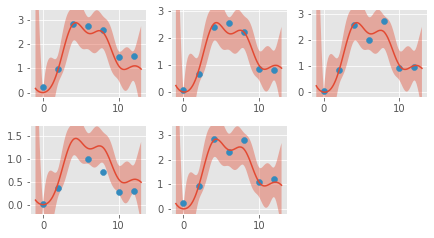

In [5]:
plotter = Plotter(model, m_df.index)

t_predict = torch.linspace(-1, 12+1, 100)
m = plotter.plot_outputs(t_predict, t_scatter=t[:7], y_scatter=m_observed[0])

dist torch.Size([7, 100])
kxf torch.Size([7, 100])
dist torch.Size([7, 100])
kxf torch.Size([7, 100])
dist torch.Size([7, 100])
kxf torch.Size([7, 100])
dist torch.Size([7, 100])
kxf torch.Size([7, 100])
dist torch.Size([7, 100])
kxf torch.Size([7, 100])
torch.Size([100, 100])


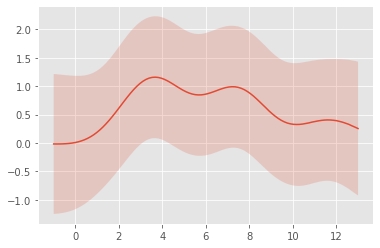

In [6]:
pred_f, var = model.predict_f(t_predict)
pred_f, var = pred_f.detach(), torch.sqrt(var).detach()
plt.plot(t_predict, pred_f)
plt.fill_between(t_predict, pred_f + var, pred_f - var, alpha=0.2)

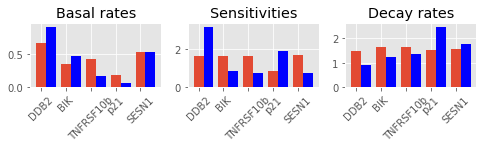

In [8]:
plotter.plot_kinetics()